In [1]:
#-*- coding: utf-8 -*-

import tensorflow as tf
# dont display much info of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any level you prefer

# limit gpu memory usage only as much as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        print("Setting memory growth to True for GPU: ", gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("Physical GPUs: ", len(gpus), "Logical GPUs: ", len(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Concatenate, Add, AveragePooling2D
import numpy as np

import matplotlib.pyplot as plt


2024-01-20 20:03:34.591055: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-20 20:03:34.658736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 20:03:34.658802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 20:03:34.661961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 20:03:34.676349: I tensorflow/core/platform/cpu_feature_guar

Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Physical GPUs:  1 Logical GPUs:  1


In [ ]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
params = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
feats = np.load(feats_path)
print("feats shape: ", feats.shape)

# use laser power and velocity as labels
params = params[:, :2]
print("y shape: ", params.shape)

y = np.concatenate((params, feats[:, 1:3]), axis=1) # L, H
print("y shape: ", y.shape)

y_max = np.max(y, axis=0)
y = y / y_max

# print max of each column
print("max of each column: ", y_max)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
feats shape:  (9587, 8)
y shape:  (9587, 2)
y shape:  (9587, 4)
max of each column:  [2750.   15.  232.  159.]


In [ ]:
# create a function to encode y
def encode_one_column(y):
    # create a new array of zeros with the same shape as y
    encoded_y = np.zeros(y.shape)
    # get the unique values in y
    unique_values = np.unique(y)
    # loop through the unique values
    for i, value in enumerate(unique_values):
        # find the indices where y equals the unique value
        indices = np.where(y == value)
        # set the indices in encoded_y to i
        encoded_y[indices] = i
    return encoded_y

# create new array to store encoded y
encoded_y = np.zeros(y.shape)
# loop through each column in y and encode it
for i in range(y.shape[1]):
    encoded_y[:, i] = encode_one_column(y[:, i])
    
# convert to int
encoded_y = encoded_y.astype(int) 

In [ ]:
# use alf of the total dataset
#manta = manta[:int(manta.shape[0]/2)]
#xiris = xiris[:int(xiris.shape[0]/2)]
#encoded_y = encoded_y[:int(encoded_y.shape[0]/2)]


In [ ]:
# crate pairs
def create_pairs(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    pairs = []
    labels = []
    binary_labels = []
    
    # Getting the indices of each class
    numclasses = len(np.unique(y_encoded))
    idx = [np.where(y_encoded==i)[0] for i in range(numclasses)]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label1 = y_encoded[idxA]

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(idx[label1])
        posImage = xiris[idxB]

        # prepare a positive pair and update the images and labels lists, respectively
        pairs.append([currentImage, posImage])
        labels.append([label1, label1])
        binary_labels.append([0])

        # grab the indices for each of the class labels not equal to the current label
        negIdx = np.where(y_encoded != label1)[0]
        
        # randomly pick an image corresponding to a label not equal to the current label
        idxC = np.random.choice(negIdx)
        label2 = y_encoded[idxC]
        negImage = xiris[idxC]
        
        # prepare a negative pair of images and update our lists
        pairs.append([currentImage, negImage])
        labels.append([label1, label2])
        binary_labels.append([1])

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(pairs), np.array(labels), np.array(binary_labels)      
                                                                                             
# create pairs
#pairs, labels, binary_labels = create_pairs(manta, xiris, y_encoded)
#print("pairs shape: ", pairs.shape)
#print("labels shape: ", labels.shape)

In [ ]:
# crate pairs
def create_pairs_2_labels(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    pairs = []
    labels = []
    
    # define numclasses with the same columns as y_encoded
    numclasses = np.zeros(y_encoded.shape[1], dtype=int)

    for i in range(y_encoded.shape[1]):
        unique_values, unique_indices = np.unique(y_encoded[:, i], return_inverse=True)
        numclasses[i] = len(unique_values)
    
    # creade idx1 and idx2
    idx1 = [np.where(y_encoded==i)[0] for i in range(numclasses[0])]
    idx2  = [np.where(y_encoded==i)[0] for i in range(numclasses[1])]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label = y_encoded[idxA]
        p1 = label[0]
        v1 = label[1]
        p2 = np.random.choice(np.delete(np.arange(numclasses[0]), p1))
        v2 = np.random.choice(np.delete(np.arange(numclasses[1]), v1))

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(np.intersect1d(idx1[p1], idx2[v1])) #np.random.choice(idx[p1][v1])
        x11 = xiris[idxB]
        # prepare a positive pair and update the images and labels lists, respectively
        pairs.append([currentImage, x11])
        labels.append([p1, v1, p1, v1])

        idxC = np.random.choice(np.intersect1d(idx1[p2], idx2[v1]))
        x21 = xiris[idxC]
        pairs.append([currentImage, x21])
        labels.append([p1, v1, p2, v1])
            
        idxD = np.random.choice(np.intersect1d(idx1[p1], idx2[v2]))
        x12 = xiris[idxD]
        pairs.append([currentImage, x12])
        labels.append([p1, v1, p1, v2])
        
        idxE = np.random.choice(np.intersect1d(idx1[p2], idx2[v2]))
        x22 = xiris[idxE]
        pairs.append([currentImage, x22])
        labels.append([p1, v1, p2, v2])
    

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(pairs), np.array(labels)       

                                                                                             
# create pairs
pairs, labels = create_pairs_2_labels(manta, xiris, encoded_y)
print("pairs shape: ", pairs.shape)
print("labels shape: ", labels.shape)

del manta, xiris, y, encoded_y

Creating pairs for image 0/9587, Completed 0%
Creating pairs for image 1000/9587, Completed 10%
Creating pairs for image 2000/9587, Completed 20%
Creating pairs for image 3000/9587, Completed 31%
Creating pairs for image 4000/9587, Completed 41%
Creating pairs for image 5000/9587, Completed 52%
Creating pairs for image 6000/9587, Completed 62%
Creating pairs for image 7000/9587, Completed 73%
Creating pairs for image 8000/9587, Completed 83%
Creating pairs for image 9000/9587, Completed 93%
pairs shape:  (38348, 2, 320, 320)
labels shape:  (38348, 4)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, shuffle=True)

del pairs, labels

# print shapes
print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape, "y_test shape: ", y_test.shape)

X_train shape:  (30678, 2, 320, 320) y_train shape:  (30678, 4)
X_test shape:  (7670, 2, 320, 320) y_test shape:  (7670, 4)


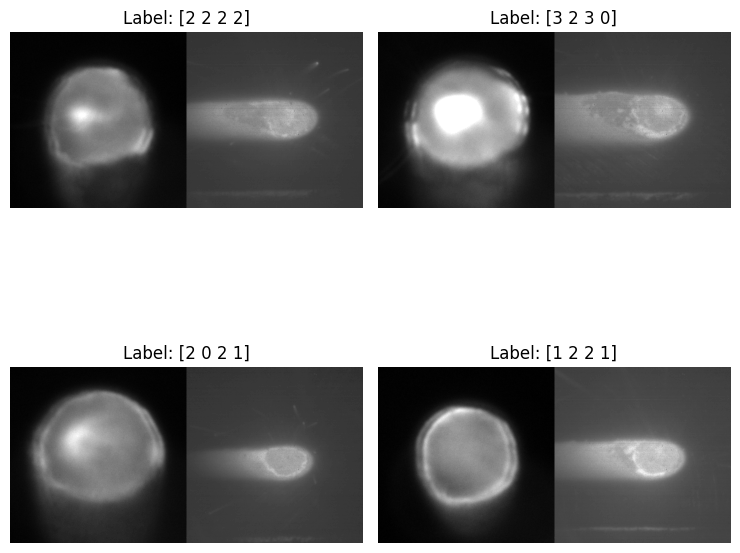

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.keras.layers.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

# visualize pairs
visualize(X_train, y_train, to_show=4, num_col=2)

In [ ]:
def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    
    x = Dense(128, activation='relu')(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# add projection head
def add_projection_head(input_shape, encoder, embedding_dim):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    features = Dense(128, activation='relu')(features)

    #outputs_p = Dense(embedding_dim, activation='relu')(features)
    #outputs_v = Dense(embedding_dim, activation='relu')(features)
    #model = Model(inputs=inputs, outputs=[outputs_p, outputs_v] )  
    model = Model(inputs=inputs, outputs=features)  
    return model

input_shape = (320, 320, 1)
embedding_dim= 128
batch_size = 64
epochs = 20
validation_split = 0.2
learning_rate = 0.0001

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)

manta = Input(shape=input_shape)
xiris = Input(shape=input_shape)

manta_encoded = encoder_with_projection_head(manta)
xiris_encoded = encoder_with_projection_head(xiris)

manta_outputs_p = Dense(embedding_dim, activation='relu')(manta_encoded)
manta_outputs_v = Dense(embedding_dim, activation='relu')(manta_encoded)

xiris_outputs_p = Dense(embedding_dim, activation='relu')(xiris_encoded)
xiris_outputs_v = Dense(embedding_dim, activation='relu')(xiris_encoded)

reg_manta_p = tf.keras.layers.Dense(1, activation="linear")(manta_outputs_p) 
reg_manta_v = tf.keras.layers.Dense(1, activation="linear")(manta_outputs_v) 

reg_xiris_p = tf.keras.layers.Dense(1, activation="linear")(xiris_outputs_p) 
reg_xiris_v = tf.keras.layers.Dense(1, activation="linear")(xiris_outputs_v) 

siamese_net = tf.keras.Model(inputs=[manta, xiris], outputs=[manta_outputs_p, manta_outputs_v, xiris_outputs_p, xiris_outputs_v, reg_manta_p, reg_manta_v, reg_xiris_p, reg_xiris_v])

siamese_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 128)                  1186918   ['input_3[0][0]',             
                                                          4          'input_4[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 128)                  16512     ['model_1[0][0]']       

In [ ]:
class SiameseModel(Model):
    """
        The Siamese Network model with a custom training and testing loops.
        Computes the contrastive loss using the two embeddings produced by the Siamese Network.
    """
    def __init__(self, siamese_network):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = 1.0
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")


    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # Unpack the data
        X, y = data  
        print(y)
        
        with tf.GradientTape() as tape:
            y_pred = self.siamese_network(X) # Forward pass
            print(y_pred)
            # compute loss
            loss = self.contrastive_loss_PV(y_true=y, y_pred=y_pred)
            loss_reg_manta_p = tf.keras.losses.MeanSquaredError()(y[:, 0], y_pred[4])
            loss_reg_manta_v = tf.keras.losses.MeanSquaredError()(y[:, 1], y_pred[5])
            loss_reg_xiris_p = tf.keras.losses.MeanSquaredError()(y[:, 2], y_pred[6])
            loss_reg_xiris_v = tf.keras.losses.MeanSquaredError()(y[:, 3], y_pred[7])
            loss = loss #+ loss_reg_manta_p + loss_reg_manta_v + loss_reg_xiris_p + loss_reg_xiris_v
            
        # Storing the gradients of the loss function with respect to the weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data): # model.evaluate() stores the losses and metrics in a list
        # Unpack the data
        X, y = data
        
        # Compute predictions
        y_pred = self.siamese_network(X, training=False)
        # The loss is computed on the test set
        loss = self.contrastive_loss_PV(y_true=y, y_pred=y_pred)
        loss_reg_manta_p = tf.keras.losses.MeanSquaredError()(y[:, 0], y_pred[4])
        loss_reg_manta_v = tf.keras.losses.MeanSquaredError()(y[:, 1], y_pred[5])
        loss_reg_xiris_p = tf.keras.losses.MeanSquaredError()(y[:, 2], y_pred[6])
        loss_reg_xiris_v = tf.keras.losses.MeanSquaredError()(y[:, 3], y_pred[7])
        loss = loss #+ loss_reg_manta_p + loss_reg_manta_v + loss_reg_xiris_p + loss_reg_xiris_v
    
        return {"loss": self.loss_tracker.result()}
    
    """ def contrastive_loss_PV(self, y_true, y_pred):
        # y_pre os embedings: of p1 v2 p2 v2
        # calculate the distance of the embeddings
        distance_p = tf.abs(y_pred[0] - y_pred[2])
        distance_v = tf.abs(y_pred[1] - y_pred[3])
        
        y_true = tf.cast(y_true, dtype=tf.float32)
        # Verify that y_true is of shape (batch_size, 4)
        if y_true.shape[1] != 4:
            raise ValueError("y_true must be of shape (batch_size, 4)")
        # Extract true labels for each task
        y_true_p = tf.cast(tf.not_equal(y_true[:, 0], y_true[:, 2]), tf.float32)
        y_true_v = tf.cast(tf.not_equal(y_true[:, 1], y_true[:, 3]), tf.float32)
        
        # calculate the loss for p
        square_pred_p = tf.square(distance_p)
        margin_square_p = tf.square(tf.maximum(self.margin - distance_p, 0))
        loss_p = tf.reduce_mean((1 - y_true_p) * square_pred_p + (y_true_p) * margin_square_p)
        
        # calculate the loss for v
        square_pred_v = tf.square(distance_v)
        margin_square_v = tf.square(tf.maximum(self.margin - distance_v, 0))
        loss_v = tf.reduce_mean((1 - y_true_v) * square_pred_v + (y_true_v) * margin_square_v)
        
        # Combine the losses using any strategy you prefer (e.g., sum or average)
        combined_loss = loss_p + loss_v
        return combined_loss 
        
    def contrastive_loss_PV(self, y_true, y_pred):
        # y_pred are embeddings: of p1 v2 p2 v2
        # calculate the distance of the embeddings
        distance_p = tf.abs(y_pred[0] - y_pred[2])
        distance_v = tf.abs(y_pred[1] - y_pred[3])

        y_true = tf.cast(y_true, dtype=tf.float32)
        # Verify that y_true is of shape (batch_size, 4)
        if y_true.shape[1] != 4:
            raise ValueError("y_true must be of shape (batch_size, 4)")
        # Extract true labels for each task
        y_true_p = tf.cast(tf.not_equal(y_true[:, 0], y_true[:, 2]), tf.float32)
        y_true_v = tf.cast(tf.not_equal(y_true[:, 1], y_true[:, 3]), tf.float32)

        # calculate the loss for p
        square_pred_p = tf.square(distance_p)
        margin_square_p = tf.square(tf.maximum(self.margin - distance_p, 0))
        loss_p = tf.reduce_mean((1 - y_true_p) * square_pred_p + (y_true_p) * margin_square_p)

        # calculate the loss for v
        square_pred_v = tf.square(distance_v)
        margin_square_v = tf.square(tf.maximum(self.margin - distance_v, 0))
        loss_v = tf.reduce_mean((1 - y_true_v) * square_pred_v + (y_true_v) * margin_square_v)

        # Combine the losses using any strategy you prefer (e.g., sum or average)
        combined_loss = loss_p + loss_v
        return combined_loss """
    
    def contrastive_loss_PV(self, y_true, y_pred):
        # Extract embeddings
        #p1, v1, p2, v2, _ = tf.split(y_pred, num_or_size_splits=[128, 128, 128, 128], axis=1)
        # Extract embeddings
        p1, v1, p2, v2 = y_pred[0], y_pred[1], y_pred[2], y_pred[3]

        # Calculate distances
        distance_p = tf.reduce_sum(tf.square(p1 - p2), axis=1, keepdims=True)
        distance_v = tf.reduce_sum(tf.square(v1 - v2), axis=1, keepdims=True)
        
        # convert to float32
        distance_p = tf.cast(distance_p, dtype=tf.float32)
        distance_v = tf.cast(distance_v, dtype=tf.float32)
        
        # squeeze distance_p and distance_v
        distance_p = tf.squeeze(distance_p, axis=-1)
        distance_v = tf.squeeze(distance_v, axis=-1)
        
        
        
        print("distance_p shape: ", distance_p)
        print("distance_v shape: ", distance_v)

        # Convert y_true to float32
        y_true = tf.cast(y_true, dtype=tf.float32)
        # Ensure margin has the same data type as distance_p and distance_v
        margin = tf.cast(self.margin, dtype=tf.float32)

        # Extract true labels for each task
        y_true_p = tf.cast(tf.not_equal(y_true[:, 0], y_true[:, 2]), tf.float32)
        y_true_v = tf.cast(tf.not_equal(y_true[:, 1], y_true[:, 3]), tf.float32)
        
        square_pred_p = tf.square(distance_p)
        margin_square_p = tf.square(tf.maximum(margin - distance_p, 0))
        loss_p = tf.reduce_mean((1 - y_true_p) * square_pred_p + (y_true_p) * margin_square_p)
        
        square_pred_v = tf.square(distance_v)
        margin_square_v = tf.square(tf.maximum(margin - distance_v, 0))
        loss_v = tf.reduce_mean((1 - y_true_v) * square_pred_v + (y_true_v) * margin_square_v)
        
    

        # Calculate the loss for p
        #loss_p = 0.5 * tf.reduce_mean((1 - y_true_p) * distance_p + y_true_p * tf.maximum(0.0, self.margin - distance_p)**2)

        # Calculate the loss for v
        #loss_v = 0.5 * tf.reduce_mean((1 - y_true_v) * distance_v + y_true_v * tf.maximum(0.0, self.margin - distance_v)**2)

        # Combine the losses
        combined_loss = loss_p + loss_v

        return combined_loss

        
        
    def contrastive_loss_PV_OLD(self, y_true, y_pred):
        """Calculates the contrastive loss."""
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)     
        y_pred = tf.squeeze(y_pred, axis=-1)
        
        # Verify that y_true is of shape (batch_size, 4)
        if y_true.shape[1] != 4:
            raise ValueError("y_true must be of shape (batch_size, 4)")

        # Extract true labels for each task
        y_true_p = tf.cast(tf.not_equal(y_true[:, 0], y_true[:, 2]), tf.float32)
        y_true_v = tf.cast(tf.not_equal(y_true[:, 1], y_true[:, 3]), tf.float32)
        
        # Reshape y_pred_p to (batch_size, 1)
        y_pred_p = y_pred[0, :]
        y_pred_v = y_pred[1, :]
        
        # squeeze y_pred_p and y_pred_v
        y_pred_p = tf.squeeze(y_pred_p, axis=-1)
        y_pred_v = tf.squeeze(y_pred_v, axis=-1)
        square_pred_p = tf.square(y_pred_p)
        margin_square_p = tf.square(tf.maximum(self.margin - y_pred_p, 0))
        loss_p = tf.reduce_mean((1 - y_true_p) * square_pred_p + (y_true_p) * margin_square_p)
        
        square_pred_v = tf.square(y_pred_v)
        margin_square_v = tf.square(tf.maximum(self.margin - y_pred_v, 0))
        loss_v = tf.reduce_mean((1 - y_true_v) * square_pred_v + (y_true_v) * margin_square_v)      

        # Combine the losses using any strategy you prefer (e.g., sum or average)
        combined_loss = loss_p + loss_v

        return combined_loss


    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
# create siamese model
siamese_model = SiameseModel(siamese_net)
# compile model
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
# fit model
siamese_model.fit(
    x=[X_train[:, 0], X_train[:, 1]], 
    y=y_train,
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=validation_split,
)

Epoch 1/20
Tensor("IteratorGetNext:2", shape=(None, 4), dtype=int64)
[<tf.Tensor 'model_2/dense_2/Relu:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'model_2/dense_3/Relu:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'model_2/dense_4/Relu:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'model_2/dense_5/Relu:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'model_2/dense_6/BiasAdd:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'model_2/dense_7/BiasAdd:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'model_2/dense_8/BiasAdd:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'model_2/dense_9/BiasAdd:0' shape=(None, 1) dtype=float32>]
distance_p shape:  Tensor("Squeeze:0", shape=(None,), dtype=float32)
distance_v shape:  Tensor("Squeeze_1:0", shape=(None,), dtype=float32)
Tensor("IteratorGetNext:2", shape=(None, 4), dtype=int64)
[<tf.Tensor 'model_2/dense_2/Relu:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'model_2/dense_3/Relu:0' shape=(None, 128) dtype=float32>, <tf.Tensor 'model_2/dense_4

2024-01-20 20:02:00.482718: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-20 20:02:00.740527: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-20 20:02:01.920254: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-20 20:02:02.787039: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe531d0d8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-20 20:02:02.787079: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-20 20:02:02.807760: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705780922.985645 1859576 device_compiler.h:186] 

192/192 [==============================] - ETA: 0s - loss: 4.6382distance_p shape:  Tensor("Squeeze:0", shape=(None,), dtype=float32)
distance_v shape:  Tensor("Squeeze_1:0", shape=(None,), dtype=float32)
192/192 [==============================] - 31s 109ms/step - loss: 4.6382 - val_loss: 0.0000e+00
Epoch 2/20
192/192 [==============================] - 13s 69ms/step - loss: 2.3972 - val_loss: 0.0000e+00
Epoch 3/20
192/192 [==============================] - 13s 69ms/step - loss: 2.0322 - val_loss: 0.0000e+00
Epoch 4/20
192/192 [==============================] - 13s 69ms/step - loss: 1.8306 - val_loss: 0.0000e+00
Epoch 5/20
192/192 [==============================] - 13s 70ms/step - loss: 1.6598 - val_loss: 0.0000e+00
Epoch 6/20
 84/192 [============>.................] - ETA: 7s - loss: 1.5921

KeyboardInterrupt: 

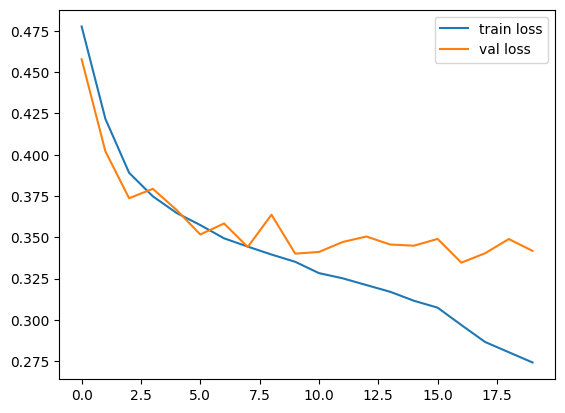

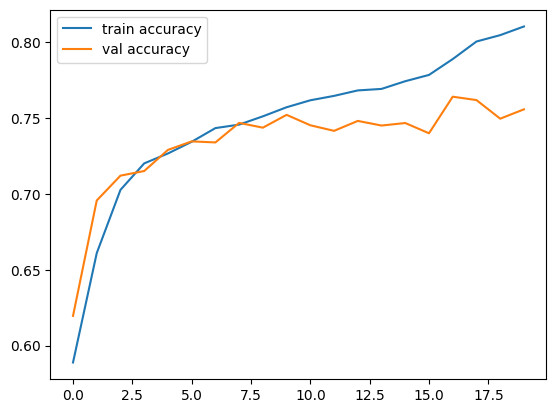

In [ ]:
# plot history
plt.plot(siamese_model.history.history['loss'], label='train loss')
plt.plot(siamese_model.history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# evaluate model
siamese_model.evaluate(x=[X_test[:, 0], X_test[:, 1]], y=y_test)

240/240 [==============================] - 6s 23ms/step - loss: 0.3400 - accuracy: 0.7568


[0.3399936258792877, 0.756776750087738]